In [21]:
# https://colab.research.google.com/drive/1ZZXnCjFEOkp_KdNcNabd14yok0BAIuwS#forceEdit=true&sandboxMode=true&scrollTo=wdPxFvHdTLRK

import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
from PIL import Image

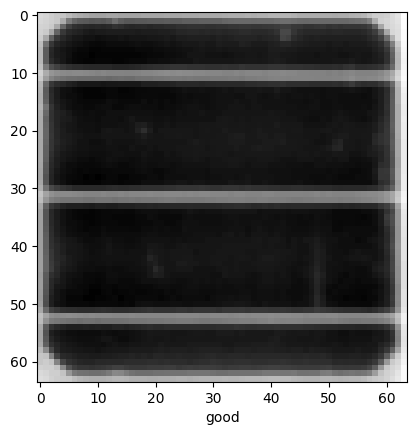

In [33]:
#  LOAD AND SPLIT DATASET
path_train = r'C:\Users\Ossi\Desktop\ImageClassification\elpv-dataset\train_with_bad_images\**\*'
path_test = r'C:\Users\Ossi\Desktop\ImageClassification\elpv-dataset\test_images\**\*'

# Prepare image data 
def img_to_np(path, resize = True, extract_labels=False):  
    img_array = []
    labels = []
    fpaths = glob.glob(path, recursive=True)
    for fname in fpaths:
        if(extract_labels): 
            if '_bad' in os.path.basename(fname):
                labels.append(1)  # 1 for outlier
            else:
                labels.append(0)  # 0 for non-outlier
        img = Image.open(fname).convert("L") # Grayscale when using "RGB" you have to change the encoder and decoder 
        if(resize): img = img.resize((64,64))
        img_array.append(np.asarray(img))
    images = np.array(img_array)
    if(extract_labels): return images, np.array(labels)
    return images

test_images, test_labels = img_to_np(path_test, extract_labels=True)
train_images, train_labels = img_to_np(path_train, extract_labels=True)

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

class_names = ['good', 'bad']

# Let's look at a one image
IMG_INDEX = 7  # change this to look at other images

plt.imshow(train_images[IMG_INDEX] ,cmap=plt.cm.binary)
plt.xlabel(class_names[train_labels[IMG_INDEX]])
#plt.show() # uncomment for prview of image


In [49]:
# building the Convolutional Base
model = models.Sequential()
#  32, 32, 3 means we will process 32 filters of size 3x3 | imput shape 64, 64, 1 means 64x64 pixels with one chanell for RGB change to 3
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 1)))
# pooling layses to downsample our feature maps and reduce their dimensions
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Add dense layers to classify into two classes true false 
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

#model.summary()

In [55]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
60/60 [==============================] - 1s 7ms/step - loss: 0.5436 - accuracy: 0.7136 - val_loss: 0.6730 - val_accuracy: 0.6161
Epoch 2/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5287 - accuracy: 0.7131 - val_loss: 0.6510 - val_accuracy: 0.6518
Epoch 3/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5100 - accuracy: 0.7342 - val_loss: 0.6168 - val_accuracy: 0.6488
Epoch 4/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5079 - accuracy: 0.7363 - val_loss: 0.6349 - val_accuracy: 0.6667
Epoch 5/10
60/60 [==============================] - 0s 5ms/step - loss: 0.5069 - accuracy: 0.7363 - val_loss: 0.6219 - val_accuracy: 0.6548
Epoch 6/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4950 - accuracy: 0.7358 - val_loss: 0.6599 - val_accuracy: 0.6339
Epoch 7/10
60/60 [==============================] - 0s 5ms/step - loss: 0.4916 - accuracy: 0.7453 - val_loss: 0.7058 - val_accuracy: 0.6577
Epoch 8/10
60/60 [==

In [56]:
# Evaluating the Model
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)

11/11 - 0s - loss: 0.6121 - accuracy: 0.6786 - 33ms/epoch - 3ms/step
0.6785714030265808
